## Setup environment

In [34]:

from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
import json
from datetime import datetime
from data_preparation2 import DataHandling 
from UNet_model import create_unet
import numpy as np
import nibabel as nib

In [38]:
data_dir = "/homes/zshahpouri/DLP/ASC-PET-001"
adcm_dir = "/homes/zshahpouri/DLP/ASC-PET-001/ADCM"

------
# First Step, Generating ADCM images

In [30]:
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
def midrange(values):
    return (np.min(values) + np.max(values)) / 2.0


def calculate_adcm(nac_img, mac_img, epsilon=0.001):

    mac_img = mac_img * 5
    nac_img = nac_img * 2
    
    # Initialize ADCM with MAC values
    adcm = np.copy(mac_img)
    
    # Only perform division where NASC-PET is greater than epsilon
    mask = nac_img > epsilon
    adcm[mask] = mac_img[mask] / nac_img[mask]
    

    # Calculate the median of medians as the normalization value
    mac_med = np.median(mac_img)
    nac_med = np.median(nac_img)
    adcm_med = np.median(adcm)
    
    # Calculate the median of the three median values
    print('median', [nac_med, mac_med, adcm_med])
    print('mean', [np.mean(mac_img), np.mean(nac_img), np.mean(adcm)])
    print('midrange', [midrange(mac_img), midrange(nac_img), midrange(adcm)])
    
    val = np.median([midrange(mac_img), midrange(nac_img), midrange(adcm)])
    
    # Normalize ADCM by this median value
    normalized_adcm = adcm / val
    
    return normalized_adcm

# Create the ADCM directory if it doesn't exist
os.makedirs(adcm_dir, exist_ok=True)

train_images = sorted(glob.glob(os.path.join(data_dir, "NAC", "*.nii.gz")))
target_images = sorted(glob.glob(os.path.join(data_dir, "MAC", "*.nii.gz")))

median [0.0, 0.014311557681028054, 0.021467336521542084]
mean [0.6834131196525596, 0.004974264286056413, 30.8008754249873]
midrange [117.23670263356156, 0.7112844167470943, 1271.2499999999998]
NAC Image: Min = 0.0, Max = 0.7112844167470943
MAC Image: Min = 0.0, Max = 46.89468105342463
ADCM Image: Min = 0.0, Max = 21.686894486847784
----------------------------------


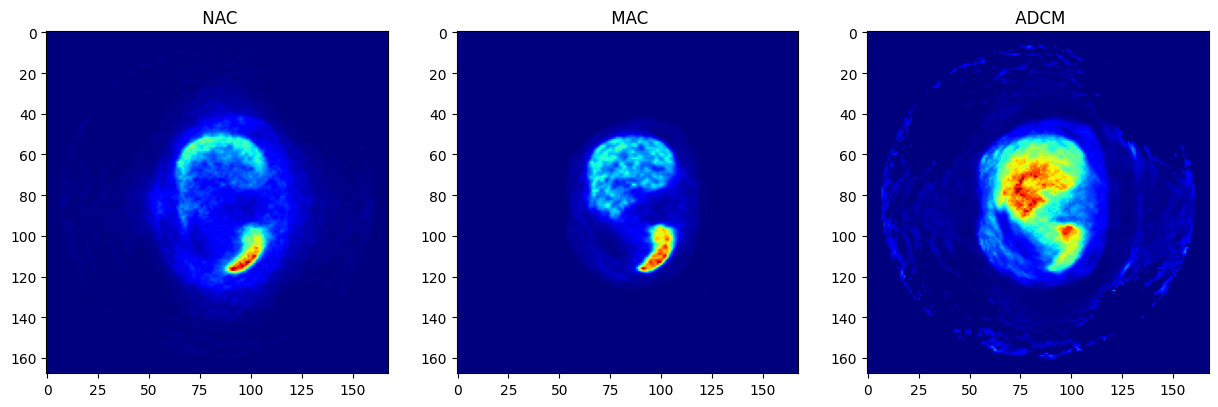

median [0.0012680717010928075, 0.009510537758196057, 0.9375000000000001]
mean [0.4146836502681795, 0.01655889475903927, 9.67397975194931]
midrange [51.93863178713503, 3.636829638734172, 481.25]
NAC Image: Min = 0.0, Max = 3.636829638734172
MAC Image: Min = 0.0, Max = 20.775452714854012
ADCM Image: Min = 0.0, Max = 18.531485464320742
----------------------------------


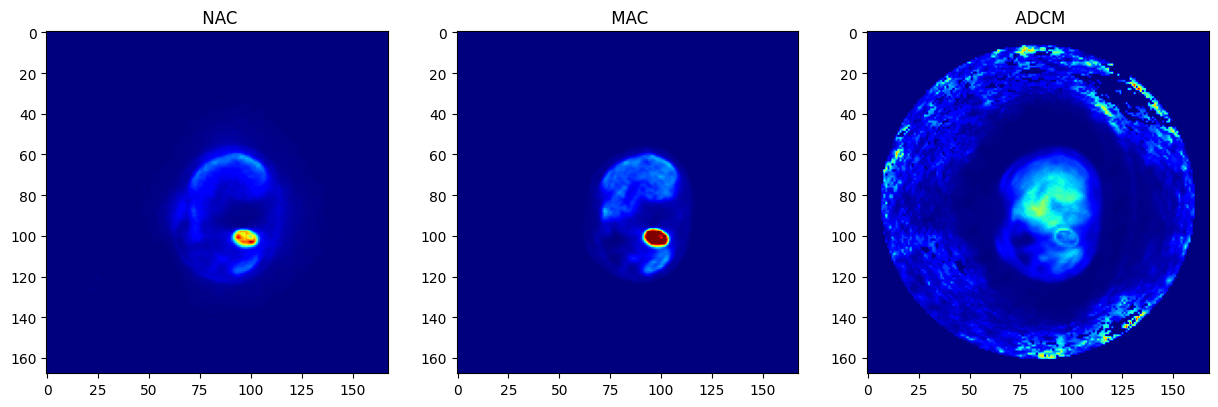

median [0.002671472293276755, 0.020036042199575665, 0.06010812659872699]
mean [0.8059319359329911, 0.009233861107270237, 23.91015579830837]
midrange [109.42016579224928, 1.3744724948908904, 956.25]
NAC Image: Min = 0.0, Max = 1.3744724948908904
MAC Image: Min = 0.0, Max = 43.76806631689971
ADCM Image: Min = 0.0, Max = 17.478496638646757
----------------------------------


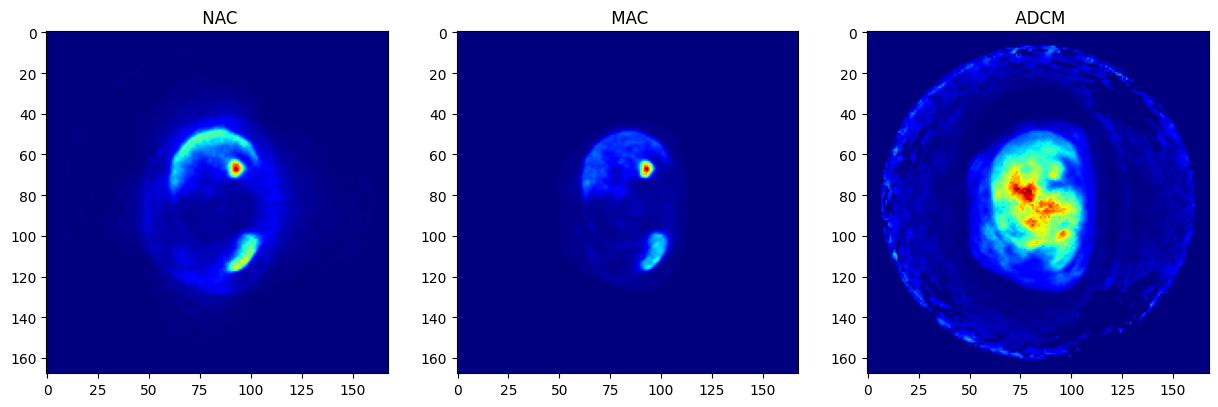

KeyboardInterrupt: 

In [31]:
import matplotlib.pyplot as plt

# Function to plot a middle slice from the Z-axis of each volume
def plot_middle_slice(nac_img, mac_img, adcm, title_prefix=''):
    slice_idx = nac_img.shape[2] // 2  # Middle slice for the Z-axis
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(nac_img[:, :, slice_idx], cmap='jet')
    axes[0].set_title(f'{title_prefix} NAC')
    
    axes[1].imshow(mac_img[:, :, slice_idx], cmap='jet')
    axes[1].set_title(f'{title_prefix} MAC')
    
    axes[2].imshow(adcm[:, :, slice_idx], cmap='jet')
    axes[2].set_title(f'{title_prefix} ADCM')
    
    plt.show()

for nac_path, mac_path in zip(train_images, target_images):
    nac_nii = nib.load(nac_path)
    nac_img = nac_nii.get_fdata()
    
    mac_nii = nib.load(mac_path)
    mac_img = mac_nii.get_fdata()
    
    adcm = calculate_adcm(nac_img, mac_img)

    # Print min and max values
    print(f"NAC Image: Min = {np.min(nac_img)}, Max = {np.max(nac_img)}")
    print(f"MAC Image: Min = {np.min(mac_img)}, Max = {np.max(mac_img)}")
    print(f"ADCM Image: Min = {np.min(adcm)}, Max = {np.max(adcm)}")
    print( "----------------------------------")
    
    plot_middle_slice(nac_img, mac_img, adcm, title_prefix="")
    


------
# Second step, Exporting ADCM images

In [32]:
for nac_path, mac_path in zip(train_images, target_images):
    # Load NAC and MAC images
    nac_nii = nib.load(nac_path)
    nac_img = nac_nii.get_fdata()
    
    mac_nii = nib.load(mac_path)
    mac_img = mac_nii.get_fdata()
    
    # Calculate ADCM using the function
    adcm = calculate_adcm(nac_img, mac_img)
    
    # Use the header from the original MAC image for ADCM image
    adcm_nii = nib.Nifti1Image(adcm.astype(np.float32), mac_nii.affine, mac_nii.header)

    # Construct the path for the output ADCM image
    adcm_filename = os.path.basename(nac_path).replace('.nii.gz', 'adcm') + '.nii.gz'
    adcm_filepath = os.path.join(adcm_dir, adcm_filename)

    # Save the ADCM Nifti image
    nib.save(adcm_nii, adcm_filepath)
    print(f"Saved ADCM image to {adcm_filepath}")


median [0.0, 0.014311557681028054, 0.021467336521542084]
mean [0.6834131196525596, 0.004974264286056413, 30.8008754249873]
midrange [117.23670263356156, 0.7112844167470943, 1271.2499999999998]
Saved ADCM image to /homes/zshahpouri/DLP/ASC-PET-001/ADCM/001093_C1_RZ_adcm.nii.gz
median [0.0012680717010928075, 0.009510537758196057, 0.9375000000000001]
mean [0.4146836502681795, 0.01655889475903927, 9.67397975194931]
midrange [51.93863178713503, 3.636829638734172, 481.25]
Saved ADCM image to /homes/zshahpouri/DLP/ASC-PET-001/ADCM/001097_C1_RZ_adcm.nii.gz
median [0.002671472293276755, 0.020036042199575665, 0.06010812659872699]
mean [0.8059319359329911, 0.009233861107270237, 23.91015579830837]
midrange [109.42016579224928, 1.3744724948908904, 956.25]
Saved ADCM image to /homes/zshahpouri/DLP/ASC-PET-001/ADCM/001101_C1_RZ_adcm.nii.gz
median [0.0017865805577453955, 0.013399354183090467, 0.0401980625492714]
mean [0.5240956531298793, 0.007750522050208909, 21.17926337842688]
midrange [73.1761064195

--------
# Final step, Creating final DL imges of ADCM Method

In [39]:
def calculate_dl_mac(nac_img, dl_adcm_img, epsilon=0.001):

    
    nac_img = nac_img
    
    dl_final = np.copy(nac_img)
    
    # Only perform division where NASC-PET is greater than epsilon
    mask = nac_img > epsilon
    dl_final[mask] = dl_adcm_img[mask] * nac_img[mask]
    
    return dl_final


import matplotlib.pyplot as plt

# Function to plot a middle slice from the Z-axis of each volume
def plot_middle_slice(nac_img, dl_adcm_im, dl_final, mac_images, title_prefix=''):
    slice_idx = nac_img.shape[2] // 2  # Middle slice for the Z-axis
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes[0].imshow(nac_img[:, :, slice_idx], cmap='jet')
    axes[0].set_title(f'{title_prefix} NAC')
    
    axes[1].imshow(dl_adcm_im[:, :, slice_idx], cmap='jet')
    axes[1].set_title(f'{title_prefix} dl_adcm')
    
    axes[2].imshow(dl_final[:, :, slice_idx], cmap='jet')
    axes[2].set_title(f'{title_prefix} dl_final')
    
    axes[3].imshow(mac_images[:, :, slice_idx], cmap='jet')
    axes[3].set_title(f'{title_prefix} MAC')
    plt.show()


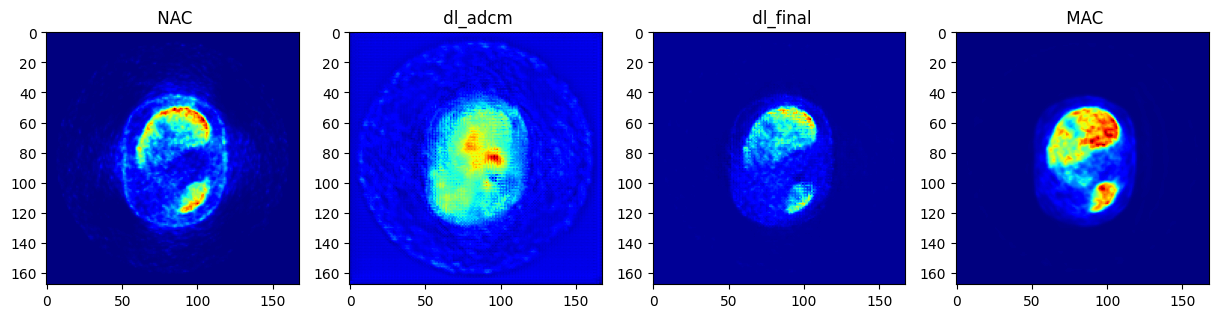

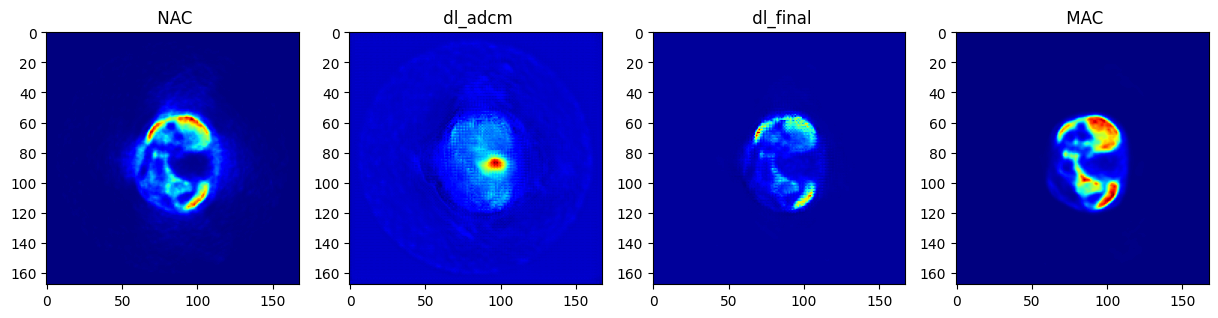

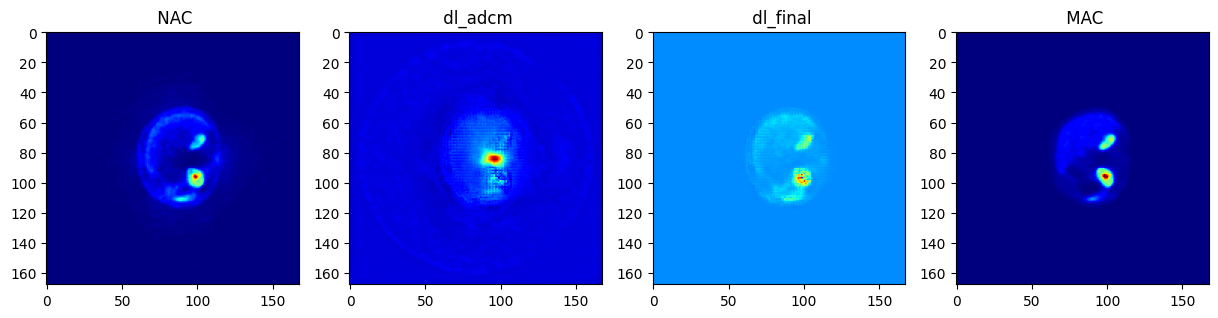

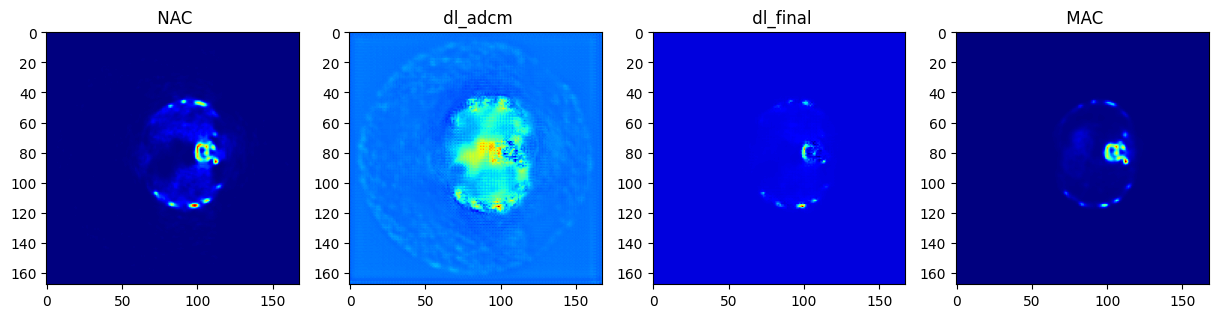

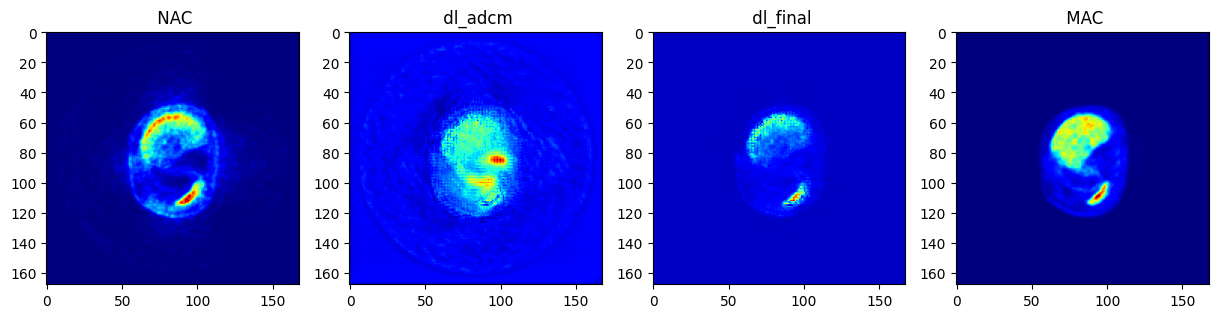

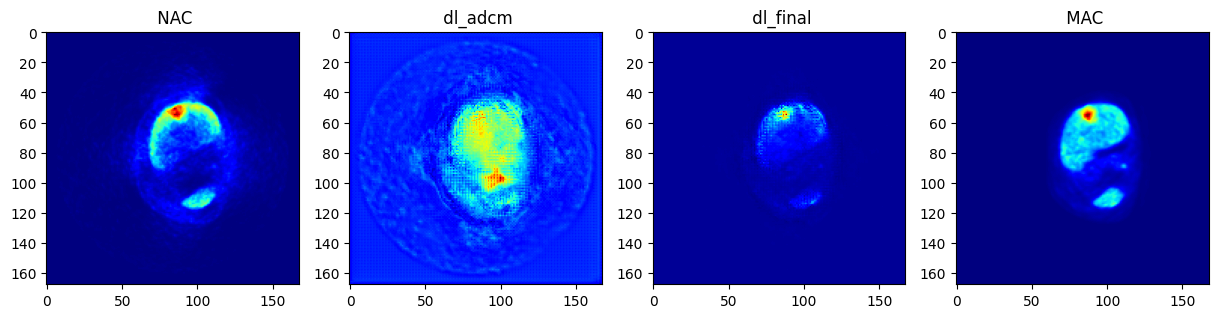

In [44]:
import os
import glob
import nibabel as nib

data_dir = "/homes/zshahpouri/DLP/ASC-PET-001"
dl_dir = '/homes/zshahpouri/DLP/Practic/OUT/'
hint = 'dl_adcm2'


def extract_id(filepath):
    # Extracts an identifier from the file path, this would depend on your file naming convention
    return os.path.basename(filepath).split('_')[0]


nac_images = sorted(glob.glob(os.path.join(data_dir, "NAC", "*.nii.gz")))
mac_images = sorted(glob.glob(os.path.join(data_dir, "MAC", "*.nii.gz")))
dl_adcm_images = sorted(glob.glob(os.path.join(dl_dir, '**/*dl_adcm2.nii.gz'), recursive=True))

# Create a dictionary to map identifiers to DL ADCM image paths
dl_adcm_dict = {extract_id(filepath): filepath for filepath in dl_adcm_images}
mac_dict = {extract_id(filepath): filepath for filepath in mac_images}

# Create pairs by matching the NAC image identifiers with those in the DL ADCM and MAC dictionaries
paired_images = [(nac_img, dl_adcm_dict[extract_id(nac_img)], mac_dict[extract_id(nac_img)]) for nac_img in nac_images if extract_id(nac_img) in dl_adcm_dict]

i = 0
for nac_path, dl_adcm_path, mac_path in paired_images:
    nac_nii = nib.load(nac_path)
    nac_img = nac_nii.get_fdata()
    
    mac_nii = nib.load(mac_path)
    mac_img = mac_nii.get_fdata()


    dl_adcm_nii = nib.load(dl_adcm_path)
    dl_adcm_im = dl_adcm_nii.get_fdata()
    
    dl_final = calculate_dl_mac(nac_img, dl_adcm_im)
    
    # Plotting the middle slice from the NAC, MAC, and ADCM images
    plot_middle_slice(nac_img, dl_adcm_im, dl_final, mac_img, title_prefix="")
    i += 1
    if i == 6:
        break


In [42]:
dl_adcm_images

[]

In [ ]:
#  'Accent', 'Accent_r', 'Blues', 
# 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 
# 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2',
# 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 
# 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 
# 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 
# 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 
# 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r',
# 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1',
# 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r',
# YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 
# fmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 
# 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 
# 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth',
# 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 
# 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r',
# 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r',
# 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 
# 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', '
# ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow',
# 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 
# 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain',
# 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 
# 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
